In [1]:
from matplotlib import pyplot as plt

import pandas as pd
import glob

%matplotlib inline

# in the notebooks directory
cd ..

# Data directory structure
We have pulled the data that we need, but the structure of the data will be difficult to deal with when we are training and testing. Create a .csv with the file paths to the images and the subdirectories

In [29]:
# one csv for each of the main datasets
mass_buildings = glob.glob('/Users/jwen/Projects/road_building_extraction/data/mass_buildings/**/*.tiff', recursive=True)
mass_roads = glob.glob('/Users/jwen/Projects/road_building_extraction/data/mass_roads/**/*.tiff', recursive=True)

mass_buildings_df = pd.DataFrame(mass_buildings)
mass_roads_df = pd.DataFrame(mass_roads)

mass_buildings_df.rename(columns={0:'file_path'}, inplace=True)
mass_roads_df.rename(columns={0:'file_path'}, inplace=True)

In [34]:
# create new column with the split 
mass_buildings_df['sat_img_path'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-1])
mass_buildings_df['map_img_path'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-1][:-1])
mass_buildings_df['sat_map'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-2])
mass_buildings_df['train_valid_test'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-3])

mass_roads_df['sat_img_path'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-1])
mass_roads_df['map_img_path'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-1][:-1])
mass_roads_df['sat_map'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-2])
mass_roads_df['train_valid_test'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-3])

In [35]:
mass_buildings_df.to_csv('/Users/jwen/Projects/road_building_extraction/data/mass_buildings/mass_buildings.csv', index=False)
mass_roads_df.to_csv('/Users/jwen/Projects/road_building_extraction/data/mass_roads/mass_roads.csv', index=False)

In [32]:
len(mass_roads_df)

1171

In [33]:
mass_roads_df.head()

,file_path,sat_img_path,map_img_path,train_valid_test
0,/Users/jwen/Projects/road_building_extraction/...,25229230_15.tiff,25229230_15.tif,valid
1,/Users/jwen/Projects/road_building_extraction/...,22528900_15.tiff,22528900_15.tif,valid
2,/Users/jwen/Projects/road_building_extraction/...,24929245_15.tiff,24929245_15.tif,valid
3,/Users/jwen/Projects/road_building_extraction/...,22829035_15.tiff,22829035_15.tif,valid
4,/Users/jwen/Projects/road_building_extraction/...,10978795_15.tiff,10978795_15.tif,valid


In [536]:
from __future__ import print_function, division
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from skimage.color import gray2rgb

import os
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# interactive mode
plt.ion()

local_path = '/Users/jwen/Projects/road_building_extraction/'

class MassRoadBuildingDataset(Dataset):
    """Massachusetts Road and Building dataset"""

    def __init__(self, csv_file, root_dir='mass_roads', train_valid_test='train', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image paths
            train_valid_test (string): 'train', 'valid', or 'test'
            root_dir (string): 'mass_roads' or 'mass_buildings'
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.train_valid_test = train_valid_test
        self.root_dir = root_dir
        self.img_path_df = self._filter_df(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_path_df)

    def __getitem__(self, idx):
        sat_img_name = os.path.join('data', self.root_dir, self.train_valid_test, 'sat',
                                    self.img_path_df.loc[idx, 'sat_img_path'])
        sat_image = io.imread(sat_img_name)

        map_img_name = os.path.join('data', self.root_dir, self.train_valid_test, 'map',
                                    self.img_path_df.loc[idx, 'map_img_path'])
        map_image = io.imread(map_img_name)

        sample = {'sat_img': sat_image, 'map_img': map_image}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

    def _filter_df(self, csv_file):
        df = pd.read_csv(csv_file)

        return df[(df['train_valid_test'] == self.train_valid_test) &
                  (df['sat_map'] != 'missing')].reset_index(drop=True)
    
    
class RescaleTarget(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        sat_img, map_img = sample['sat_img'], sample['map_img']

        h, w = sat_img.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        sat_img = transform.resize(sat_img, (new_h, new_w))

        map_img = transform.resize(map_img, (new_h, new_w))

        return {'sat_img': sat_img, 'map_img': map_img}
    
    
class RandomRotationTarget(object):
    """ Rotate the image and target randomly in a sample.
    
    Args: 
        degrees (tuple or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resize (boolean): Expand the image to fit 
    """
    def __init__(self, degrees, resize=False):
        if isinstance(degrees, int):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if isinstance(degrees, tuple):
                raise ValueError("Degrees needs to be either an int or tuple")
            self.degrees = degrees
            
        assert isinstance(resize, bool)
        
        self.resize = resize
        self.angle = np.random.uniform(self.degrees[0], self.degrees[1])
        
    def __call__(self, sample):
        
        sat_img = transform.rotate(sample['sat_img'], self.angle, self.resize)
        map_img = transform.rotate(sample['map_img'], self.angle, self.resize)

        return {'sat_img': sat_img, 'map_img': map_img}
    
    
class RandomCropTarget(object):
    """
    Crop the image and target randomly in a sample.
    
    Args:
    output_size (tuple or int): Desired output size. If int, square crop
        is made.

    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):

        sat_img, map_img = sample['sat_img'], sample['map_img']

        h, w = sat_img.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        sat_img = sat_img[top: top + new_h,left: left + new_w]
        map_img = map_img[top: top + new_h,left: left + new_w]

        return {'sat_img': sat_img, 'map_img': map_img}

    
class ToTensorTarget(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sat_img, map_img = sample['sat_img'], sample['map_img']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        sat_img = sat_img.transpose((2, 0, 1))
        return {'sat_img': torch.from_numpy(sat_img),
                'map_img': torch.from_numpy(map_img)}

In [544]:
# helper function for viewing images
def show_map(sat_img, map_img=None, sat_img_path=None, axis=None):
    """
    Return an image with the shape mask if there is one supplied
    """

    if axis:
        axis.imshow(sat_img)

        if map_img is not None:
            axis.imshow(map_img, alpha=0.5, cmap='gray')

    else:
        plt.imshow(sat_img)

        if map_img is not None:
            plt.imshow(map_img, alpha=0.5, cmap='gray')


# helper function to show a batch
def show_map_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    sat_img_batch, map_img_batch = \
            sample_batched['sat_img'], sample_batched['map_img']
    batch_size = len(sat_img_batch)
    img_size = sat_img_batch.size(2)

    f, ax = plt.subplots(int(np.ceil(batch_size/3)), 3, figsize=(15,int(np.ceil(batch_size/3))*5))
    f.tight_layout()
    f.subplots_adjust(hspace = .05, wspace=.05)
    ax = ax.ravel()
    
    for i in range(batch_size):
        print(type(ax[i]))
        ax[i].axis('off')
        show_map(sat_img=sat_img_batch.numpy()[i,:,:,:].transpose((1, 2, 0)), 
                 map_img=map_img_batch.numpy()[i,:,:], axis=ax[i])

In [537]:
mass_dataset = MassRoadBuildingDataset('/Users/jwen/Projects/road_building_extraction/data/mass_roads/mass_roads.csv','mass_roads','train',
                                       transform=transforms.Compose([RandomRotationTarget(45,resize=True),RandomCropTarget(768),
                                                                    ToTensorTarget()]))


In [538]:
dataloader = DataLoader(mass_dataset, batch_size=6, num_workers=4)

In [539]:
blah = next(iter(dataloader))

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


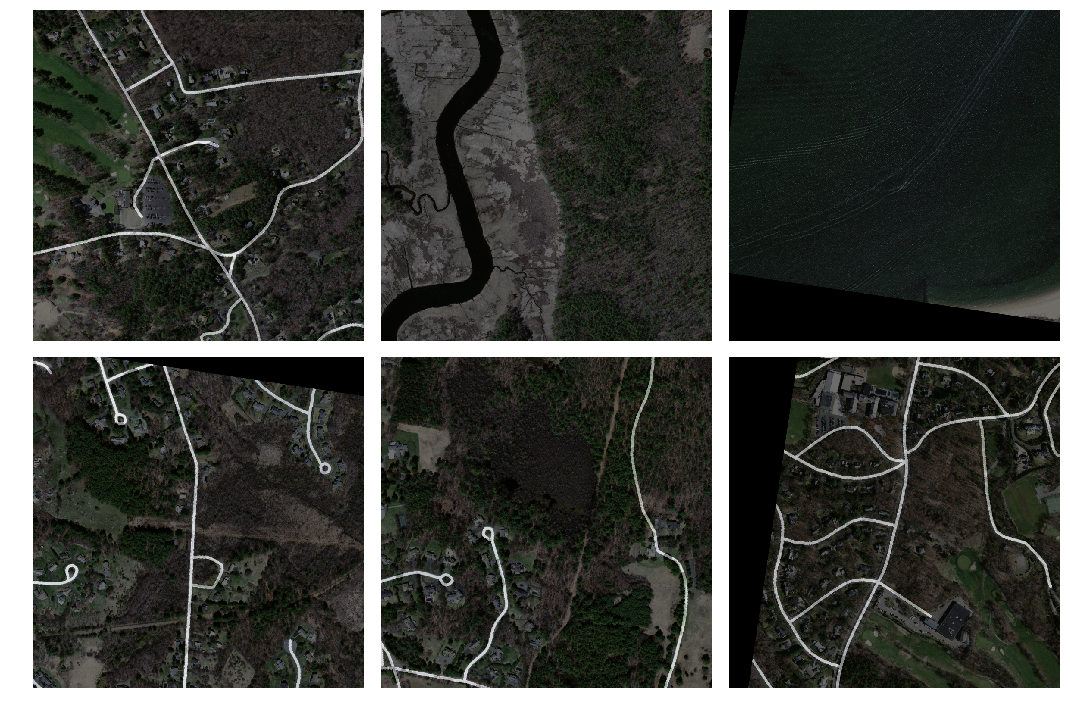

In [545]:
show_map_batch(blah)